# Train Interspeech

## Data

In [1]:
import pandas as pd

# Cargar el CSV
data = pd.read_csv('data.csv')
print(len(data))
# Eliminar filas con valores nulos solo en la columna 'text'
data = data.dropna(subset=['text'])
print(len(data))

data = data[~data['EmoClass'].isin(['X', 'O'])]

data.head()

116221
116193


,FileName,text,EmoClass,EmoAct,EmoVal,EmoDom,SpkrID,Gender,Split_Set
0,MSP-PODCAST_2432_0200,... happening there as well. and you have the ...,S,2.800000,2.200000,3.40,1425,Male,Train
1,MSP-PODCAST_0133_0033,look they're - they're reporting on absolute ...,D,6.800000,2.800000,6.60,54,Male,Development
2,MSP-PODCAST_0288_0019,"mr. [excess 00:01:24] also known as ike, bbc r...",H,5.333333,5.416667,4.75,123,Male,Train
3,MSP-PODCAST_2546_0333_0003,and instead of us just handing people masks...,H,4.600000,4.000000,4.80,1644,Male,Development
4,MSP-PODCAST_3820_0101_0000,or you're just done with all of the stuff that...,N,4.200000,3.400000,4.40,2289,Female,Train


In [2]:
# Filtrar los datos en tres conjuntos basados en la columna 'Split_Set'
train_df = data.loc[data['Split_Set'] == 'Train']
dev_df = data.loc[data['Split_Set'] == 'Development']
test_df = data.loc[data['Split_Set'] == 'Test']

# Verifica las primeras filas de cada conjunto
print("Conjunto Train:")
print(train_df.head())

print("Conjunto Development:")
print(dev_df.head())

print("Conjunto Test:")
print(test_df.head())

Conjunto Train:
                     FileName  \
0       MSP-PODCAST_2432_0200   
2       MSP-PODCAST_0288_0019   
4  MSP-PODCAST_3820_0101_0000   
6       MSP-PODCAST_0545_0449   
7       MSP-PODCAST_5492_2849   

                                                text EmoClass    EmoAct  \
0  ... happening there as well. and you have the ...        S  2.800000   
2  mr. [excess 00:01:24] also known as ike, bbc r...        H  5.333333   
4  or you're just done with all of the stuff that...        N  4.200000   
6  man, the power of contrast is so, i think, eas...        N  3.200000   
7  ... we're older. so why not allow a little bit...        A  5.400000   

     EmoVal  EmoDom  SpkrID  Gender Split_Set  
0  2.200000    3.40    1425    Male     Train  
2  5.416667    4.75     123    Male     Train  
4  3.400000    4.40    2289  Female     Train  
6  3.800000    3.80     227    Male     Train  
7  2.400000    5.00    2889    Male     Train  
Conjunto Development:
                      Fi

In [3]:
# Establecer la semilla para garantizar reproducibilidad
seed = 42

# Seleccionar aleatoriamente las primeras N filas del conjunto de entrenamiento
train_df = train_df.sample(n=100, random_state=seed)

# Seleccionar aleatoriamente las primeras N filas del conjunto de desarrollo
dev_df = dev_df.sample(n=250, random_state=seed)

In [4]:
# Verificar las etiquetas únicas en EmoClass antes de mapear
print("Etiquetas únicas en 'EmoClass' antes del mapeo:")
print(train_df['EmoClass'].unique())


Etiquetas únicas en 'EmoClass' antes del mapeo:
['S' 'H' 'N' 'C' 'A' 'F' 'U' 'D']


In [5]:
num_labels = 10
id2label = {
    0: "A",
    1: "S",
    2: "H",
    3: "U",
    4: "F",
    5: "D",
    6: "C",
    7: "N",
}
label2id = {
    "A": 0,
    "S": 1,
    "H": 2,
    "U": 3,
    "F": 4,
    "D": 5,
    "C": 6,
    "N": 7
}

# Convertir EmoClass a valores numéricos si es necesario
train_df['EmoClass'] = train_df['EmoClass'].map(label2id).astype(int)
dev_df['EmoClass'] = dev_df['EmoClass'].map(label2id).astype(int)

In [6]:
import configparser
import openai
from pydantic import BaseModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm

class ResponseFormat(BaseModel):
    emotion: str

config = configparser.ConfigParser()
config.read('config.ini')

OPENAI_MODEL = config['DEFAULT']['OPENAI_MODEL']
openai.api_key = config['DEFAULT']['OPENAI_API_KEY']

# Lista para almacenar las predicciones
predictions = []

# Loop de predicción
for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Processing predictions"):
    transcript = row['text']
    try:
        completion = openai.beta.chat.completions.parse(
            model=OPENAI_MODEL,
            messages=[
                {
                    "role": "system", 
                    "content": "You are an assistant that classifies emotions based on transcripts."
                },
                {
                    "role": "user", 
                    "content": f"Classify this transcript into one of the following emotions: Angry (A), Sad (S), Happy (H), Surprise (U), Fear (F), Disgust (D), Contempt (C), Neutral (N). Transcript: {transcript}. Output only the letter that corresponds to the emotion."
                }
            ]
        )
        # Extraer la respuesta
        response_message = completion.choices[0].message.content
        emotion = response_message.strip()
        predictions.append(emotion)
        #print(f"Predicción en el índice {idx}: {emotion}")
    except Exception as e:
        print(f"Error en el índice {idx}: {e}")
        predictions.append(None)  # Manejo de errores: insertar None en caso de fallo

# Add predictions to the DataFrame
train_df['predicted_emotion'] = predictions

Processing predictions: 100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


In [7]:
def compute_metrics(true_labels, predicted_labels):

    # Obtener reporte completo
    report = classification_report(true_labels, predicted_labels, output_dict=True)
    
    # Obtener la matriz de confusión
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    # Extraer métricas para cada clase y globales
    metrics = {
        'accuracy': report['accuracy'],
        'weighted_f1': report['weighted avg']['f1-score'],
        'macro_f1': report['macro avg']['f1-score'],
        # 'weighted_precision': report['weighted avg']['precision'],
        # 'weighted_recall': report['weighted avg']['recall'],
        # La matriz de confusión no se incluye normalmente como una métrica devuelta porque no es un escalar
        'confusion_matrix': conf_matrix.tolist()  # Convertir a lista para asegurarse de que es serializable si es necesario
    }
    
    # # Añadir métricas específicas por clase si se requiere
    # for label, scores in report.items():
    #     if label not in ["accuracy", "macro avg", "weighted avg"]:
    #         metrics[f'{label}_precision'] = scores['precision']
    #         metrics[f'{label}_recall'] = scores['recall']
    #         metrics[f'{label}_f1'] = scores['f1-score']
    #         metrics[f'{label}_support'] = scores['support']
    
    return metrics

In [11]:
true_labels = train_df['EmoClass'].dropna()
predicted_labels = train_df['predicted_emotion'].map(label2id).dropna()


metrics = compute_metrics(true_labels, predicted_labels)
metrics

{'accuracy': 0.59,
 'weighted_f1': 0.5845481233742104,
 'macro_f1': 0.2904171311780007,
 'confusion_matrix': [[5, 0, 2, 0, 0, 1, 0, 0],
  [0, 3, 2, 0, 1, 0, 0, 1],
  [0, 2, 7, 2, 1, 0, 1, 10],
  [0, 1, 0, 0, 0, 0, 0, 1],
  [0, 0, 0, 0, 0, 0, 0, 1],
  [0, 0, 0, 0, 0, 0, 0, 1],
  [0, 0, 0, 0, 0, 1, 0, 4],
  [0, 2, 2, 0, 0, 3, 2, 44]]}

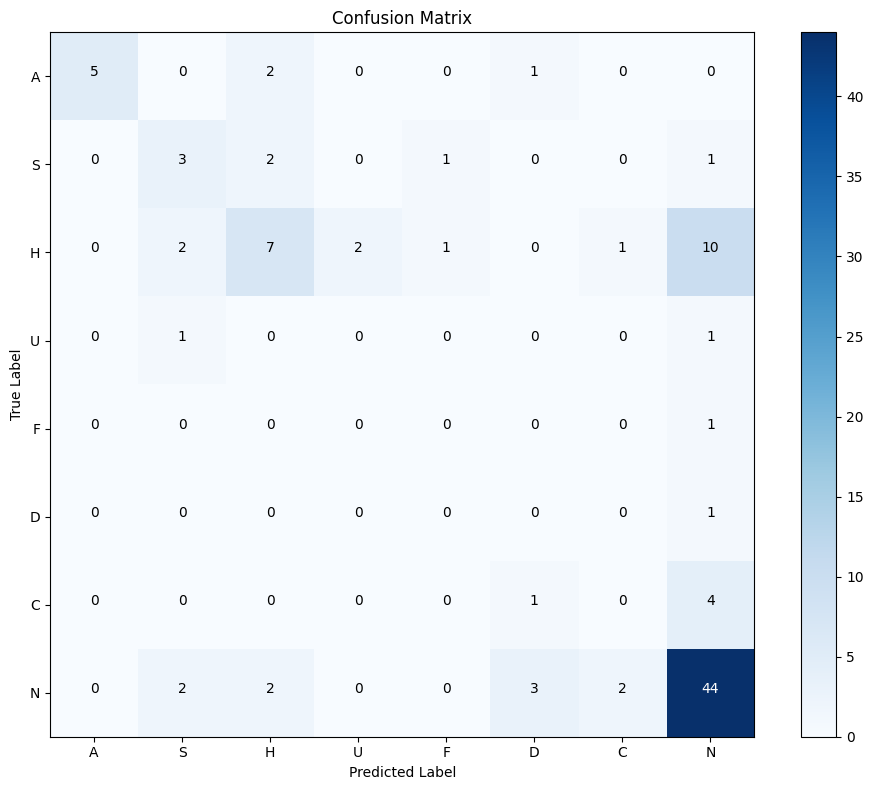

In [12]:
import matplotlib.pyplot as plt
import numpy as np

labels = label2id.keys()
conf_matrix = metrics['confusion_matrix']

# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Agregar etiquetas
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# Rótulos de valores dentro de cada celda
conf_matrix = np.array(conf_matrix)

# Calcular el umbral
thresh = conf_matrix.max() / 2
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(
        j, i, format(conf_matrix[i, j], 'd'),
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black"
    )

# Etiquetas de los ejes
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()